The purpose of this note book is to apply the profit optiisation model to make predictions based on a set of met office data. This can then also be compared to Manon's results.

The code bellow imports the necessary python packages.

In [1]:
import sys
sys.path.append('../')

from src.vapour_pressure_deficit_calculation import vapour_pressure_deficit
from src.cumulative_Weibull_distribution_model import CumulativeWeibullDistribution, cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials
from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.rubisco_CO2_and_O_model import RubiscoRates
from src.electron_transport_rate_model import ElectronTransportRateModel

# -- Temperature dependency models --
from src.TemperatureDependenceModels.arrhenius_and_peaked_arrhenius_function import PeakedArrheniusModel, ArrheniusModel
from src.TemperatureDependenceModels.Q10_temperature_dependence_model import Q10TemperatureDependenceModel
from src.TemperatureDependenceModels.temperature_dependence_model import LowTemperatureAdjustedModel

# -- Photosynthesis models --
from src.PhotosynthesisModels.photosynthesis_model import PhotosynthesisModel
from src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelRubiscoLimitedBonan as PhotosynthesisModelRubiscoLimited
from src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelElectronTransportLimitedBonan as PhotosynthesisModelElectronTransportLimited

# -- Profit Models --
from src.ProfitModels.CO2GainModels.CO2_gain_profit_max_model import ProfitMaxCO2GainModel as CO2GainModel
from src.ProfitModels.HydraulicCostModels.hydraulic_cost_profit_max_model import ProfitMaxHydraulicCostModel as HydraulicCostModel
from src.ProfitModels.profit_max_model import ProfitMaxModel
from src.ProfitModels.profit_optimisation_model import run_optimisation_model_on_data

from src.conversions import (magnitude_conversion,
                             mole_carbon_to_grams,
                             per_day_to_per_second,
                             per_second_to_per_half_hour,
                             convert_transpiration_rate_to_latent_energy,
                             short_wave_to_photosynthetically_active_radiation,
                             light_energy_in_joules_to_micro_moles_of_light,
                             degrees_kelvin_to_centigrade,
                             convert_stomatal_conductance_of_carbon_to_water)

from xarray import open_dataset
from pandas import DataFrame, date_range
from numpy import nan

from matplotlib import pyplot as plt

# Metoffice data

To run the model we need a set of environmental data, this we get from a netcdf file. The code bellow imports and prints a description of this file.

In [2]:
metoffice_data_file_address = "../../Example met data/Alice_Holt/data/UK-Ham_2002-2003_Met.nc"

metoffice_data_file = open_dataset(metoffice_data_file_address, decode_times = False)

print(metoffice_data_file)

<xarray.Dataset>
Dimensions:    (time: 17520, z: 1, y: 1, x: 1)
Coordinates:
  * time       (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
  * z          (z) float64 1.0
  * y          (y) float64 1.0
  * x          (x) float64 1.0
Data variables:
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
    SWdown     (time, y, x) float64 ...
    Tair       (time, y, x) float64 ...
    Precip     (time, y, x) float64 ...
    Qair       (time, y, x) float64 ...
    Wind       (time, y, x) float64 ...
    Psurf      (time, y, x) float64 ...
    LWdown     (time, y, x) float64 ...
    CO2air     (time, z, y, x) float64 ...
    za_tq      (y, x) float64 ...
    za_uv      (y, x) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com


We can take a closer look at the available data "columns" using the keys property.

In [3]:
print(metoffice_data_file.keys)

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:    (time: 17520, z: 1, y: 1, x: 1)
Coordinates:
  * time       (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
  * z          (z) float64 1.0
  * y          (y) float64 1.0
  * x          (x) float64 1.0
Data variables:
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
    SWdown     (time, y, x) float64 ...
    Tair       (time, y, x) float64 ...
    Precip     (time, y, x) float64 ...
    Qair       (time, y, x) float64 ...
    Wind       (time, y, x) float64 ...
    Psurf      (time, y, x) float64 ...
    LWdown     (time, y, x) float64 ...
    CO2air     (time, z, y, x) float64 ...
    za_tq      (y, x) float64 ...
    za_uv      (y, x) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com>


Alternativly you can inspect a netcdf file without the need to write python code. For example to view the header of the netcdf file from the terminal use the following command: 

$$ \text{ncdump -h file_address} $$

Note the -h restricts the output to only the header, if it is removed the entier file is printed. 

Alternativly for a graphical interface you can open the file using nasas panoply software (https://www.giss.nasa.gov/tools/panoply/download/).

From this file we only want a subset of the columns, specificaly air temperature, specific humidity, air pressure at the ground surface, the $CO_2$ fraction of the air and the amount of incident shortwave radiation. These columns are labeld Tair, Qair, Psurf, CO2air and SWdown respectivly. The code bellow reduces the data to just these columns.

In [4]:
met_columns = ["Tair", "Qair", "Psurf", "CO2air", "SWdown"]
metoffice_data = metoffice_data_file[met_columns]

print(metoffice_data)

<xarray.Dataset>
Dimensions:  (time: 17520, y: 1, x: 1, z: 1)
Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
  * z        (z) float64 1.0
  * y        (y) float64 1.0
  * x        (x) float64 1.0
Data variables:
    Tair     (time, y, x) float64 ...
    Qair     (time, y, x) float64 ...
    Psurf    (time, y, x) float64 ...
    CO2air   (time, z, y, x) float64 ...
    SWdown   (time, y, x) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com


We can see that each column is actualy three dimentional. The first dimension coressponds to the time at wich the measurment is conducted. The remaining two dimentions "x" and "y" are needed when running simulations over a grid of adjacent sites, and "z" is used to brake the atmospher into different cells. The data in this particular file only uses one site and a single hight cell so we can remove these three diemtions.

In [5]:
metoffice_data = metoffice_data.squeeze(dim=["x", "y", "z"], drop = True)

print(metoffice_data)

<xarray.Dataset>
Dimensions:  (time: 17520)
Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
Data variables:
    Tair     (time) float64 ...
    Qair     (time) float64 ...
    Psurf    (time) float64 ...
    CO2air   (time) float64 ...
    SWdown   (time) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com


Next we convert this into a pandas data frame to make it easier to work with.

In [6]:
metoffice_data = metoffice_data.to_pandas()

print(metoffice_data)

               Tair      Qair     Psurf  CO2air  SWdown
time                                                   
0.0         289.322  0.006778  101608.0  418.56     0.0
1800.0      289.322  0.006778  101608.0  418.56     0.0
3600.0      287.886  0.006796  101628.0  418.56     0.0
5400.0      287.886  0.006796  101628.0  418.56     0.0
7200.0      286.193  0.006731  101659.0  418.56     0.0
...             ...       ...       ...     ...     ...
31527000.0  285.735  0.006571   99948.7  418.56     0.0
31528800.0  286.414  0.006736   99905.7  418.56     0.0
31530600.0  286.414  0.006736   99905.7  418.56     0.0
31532400.0  285.521  0.007251   99803.2  418.56     0.0
31534200.0  285.521  0.007251   99803.2  418.56     0.0

[17520 rows x 5 columns]


Inorder to run the profit optimisation model we need the vapour pressure deficit in $kPa$.

In [7]:
metoffice_data['VPD'] = vapour_pressure_deficit(metoffice_data['Tair'],  # K
                                                metoffice_data['Qair'],  # kg kg-1
                                                metoffice_data['Psurf'], # Pa
                                                minimum = 0.05) # kPa

print(metoffice_data)

               Tair      Qair     Psurf  CO2air  SWdown       VPD
time                                                             
0.0         289.322  0.006778  101608.0  418.56     0.0  0.735601
1800.0      289.322  0.006778  101608.0  418.56     0.0  0.735601
3600.0      287.886  0.006796  101628.0  418.56     0.0  0.570751
5400.0      287.886  0.006796  101628.0  418.56     0.0  0.570751
7200.0      286.193  0.006731  101659.0  418.56     0.0  0.406239
...             ...       ...       ...     ...     ...       ...
31527000.0  285.735  0.006571   99948.7  418.56     0.0  0.405833
31528800.0  286.414  0.006736   99905.7  418.56     0.0  0.446249
31530600.0  286.414  0.006736   99905.7  418.56     0.0  0.446249
31532400.0  285.521  0.007251   99803.2  418.56     0.0  0.278827
31534200.0  285.521  0.007251   99803.2  418.56     0.0  0.278827

[17520 rows x 6 columns]


It is also necessary to calculate the amount of photosyntheticaly active radiation from the short wave radiation.

In [8]:
metoffice_data['Photosynthetically active radiation'] = short_wave_to_photosynthetically_active_radiation(metoffice_data['SWdown'])

metoffice_data['Photosynthetically active radiation'] = light_energy_in_joules_to_micro_moles_of_light(metoffice_data['Photosynthetically active radiation'])

print(metoffice_data)

               Tair      Qair     Psurf  CO2air  SWdown       VPD  \
time                                                                
0.0         289.322  0.006778  101608.0  418.56     0.0  0.735601   
1800.0      289.322  0.006778  101608.0  418.56     0.0  0.735601   
3600.0      287.886  0.006796  101628.0  418.56     0.0  0.570751   
5400.0      287.886  0.006796  101628.0  418.56     0.0  0.570751   
7200.0      286.193  0.006731  101659.0  418.56     0.0  0.406239   
...             ...       ...       ...     ...     ...       ...   
31527000.0  285.735  0.006571   99948.7  418.56     0.0  0.405833   
31528800.0  286.414  0.006736   99905.7  418.56     0.0  0.446249   
31530600.0  286.414  0.006736   99905.7  418.56     0.0  0.446249   
31532400.0  285.521  0.007251   99803.2  418.56     0.0  0.278827   
31534200.0  285.521  0.007251   99803.2  418.56     0.0  0.278827   

            Photosynthetically active radiation  
time                                             
0.

The model takes in the srface air pressure in $\text{kPa}$ so we need to convert from $\text{Pa}$

In [9]:
metoffice_data['Psurf'] = magnitude_conversion(metoffice_data['Psurf'], '', 'k')

The $\text{CO}_2$ concetration is currently in parts per million which is equivilent to $\mu \text{mol mol}^{-1}$ so there is no need to convert this.

In [10]:
print(metoffice_data['CO2air'])

time
0.0           418.56
1800.0        418.56
3600.0        418.56
5400.0        418.56
7200.0        418.56
               ...  
31527000.0    418.56
31528800.0    418.56
31530600.0    418.56
31532400.0    418.56
31534200.0    418.56
Name: CO2air, Length: 17520, dtype: float64


The time column here is not in the format we necesseraly want so lets create another column with the date and time of each measurement.

In [11]:
units, reference_date = metoffice_data_file.time.attrs['units'].split('since')

start = reference_date.strip()[0:19].replace("-","/")

metoffice_data['date time'] = date_range(start = start, periods = len(metoffice_data), freq = '30MIN')

metoffice_data = metoffice_data.set_index('date time')

print(metoffice_data)

                        Tair      Qair     Psurf  CO2air  SWdown       VPD  \
date time                                                                    
2022-01-01 00:00:00  289.322  0.006778  101.6080  418.56     0.0  0.735601   
2022-01-01 00:30:00  289.322  0.006778  101.6080  418.56     0.0  0.735601   
2022-01-01 01:00:00  287.886  0.006796  101.6280  418.56     0.0  0.570751   
2022-01-01 01:30:00  287.886  0.006796  101.6280  418.56     0.0  0.570751   
2022-01-01 02:00:00  286.193  0.006731  101.6590  418.56     0.0  0.406239   
...                      ...       ...       ...     ...     ...       ...   
2022-12-31 21:30:00  285.735  0.006571   99.9487  418.56     0.0  0.405833   
2022-12-31 22:00:00  286.414  0.006736   99.9057  418.56     0.0  0.446249   
2022-12-31 22:30:00  286.414  0.006736   99.9057  418.56     0.0  0.446249   
2022-12-31 23:00:00  285.521  0.007251   99.8032  418.56     0.0  0.278827   
2022-12-31 23:30:00  285.521  0.007251   99.8032  418.56     0.0

Lets plot the values from the metofice data that are to be input into the optimisation model.

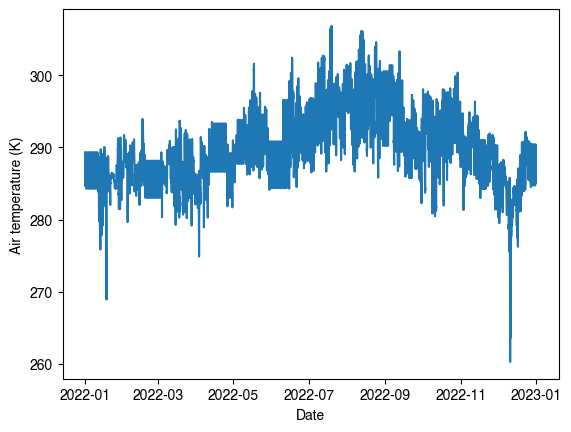

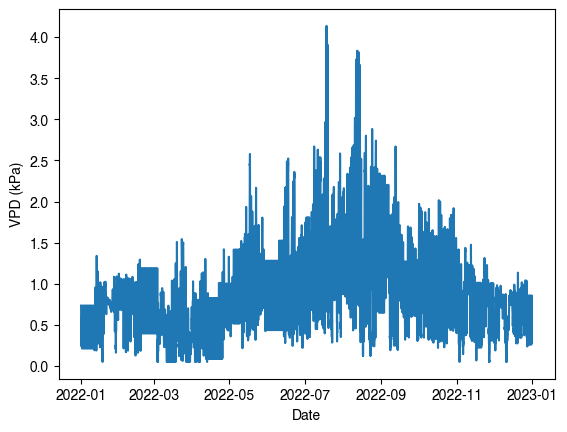

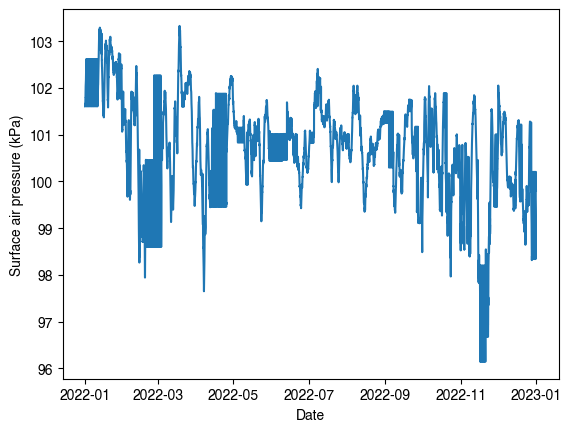

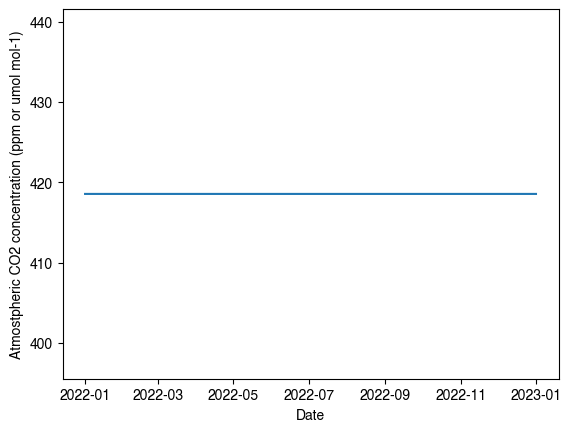

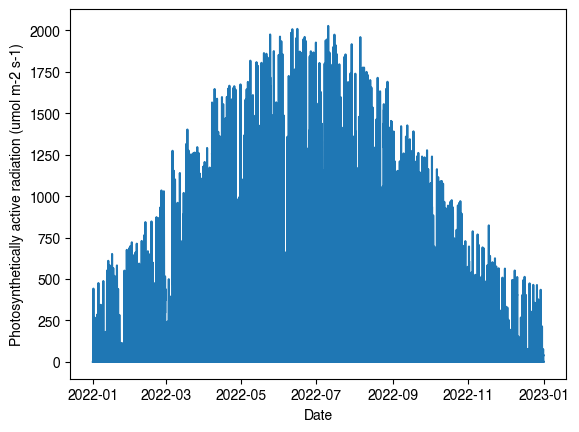

In [12]:
plt.plot(metoffice_data.index, metoffice_data['Tair'])
plt.xlabel("Date")
plt.ylabel("Air temperature (K)")
plt.show()

plt.plot(metoffice_data.index, metoffice_data['VPD'])
plt.xlabel("Date")
plt.ylabel("VPD (kPa)")
plt.show()

plt.plot(metoffice_data.index, metoffice_data['Psurf'])
plt.xlabel("Date")
plt.ylabel("Surface air pressure (kPa)")
plt.show()

plt.plot(metoffice_data.index, metoffice_data['CO2air'])
plt.xlabel("Date")
plt.ylabel("Atmostpheric CO2 concentration (ppm or umol mol-1)")
plt.show()

plt.plot(metoffice_data.index, metoffice_data['Photosynthetically active radiation'])
plt.xlabel("Date")
plt.ylabel("Photosynthetically active radiation (umol m-2 s-1)")
plt.show()

## Missing model inputs

The data available within the file doesn't contain the soil water potential or intercellular oxygen concentration. We elect to set the value for the intercellular oxygen as a constant with time. The code used later takes this values in as an array of the same size as time steps so we need to create one and add it to the pandas data frame.

In [13]:
intercellular_oxygen = 210.0 #(umol mol-1)

metoffice_data['intercellular oxygen'] = intercellular_oxygen

print(metoffice_data)

                        Tair      Qair     Psurf  CO2air  SWdown       VPD  \
date time                                                                    
2022-01-01 00:00:00  289.322  0.006778  101.6080  418.56     0.0  0.735601   
2022-01-01 00:30:00  289.322  0.006778  101.6080  418.56     0.0  0.735601   
2022-01-01 01:00:00  287.886  0.006796  101.6280  418.56     0.0  0.570751   
2022-01-01 01:30:00  287.886  0.006796  101.6280  418.56     0.0  0.570751   
2022-01-01 02:00:00  286.193  0.006731  101.6590  418.56     0.0  0.406239   
...                      ...       ...       ...     ...     ...       ...   
2022-12-31 21:30:00  285.735  0.006571   99.9487  418.56     0.0  0.405833   
2022-12-31 22:00:00  286.414  0.006736   99.9057  418.56     0.0  0.446249   
2022-12-31 22:30:00  286.414  0.006736   99.9057  418.56     0.0  0.446249   
2022-12-31 23:00:00  285.521  0.007251   99.8032  418.56     0.0  0.278827   
2022-12-31 23:30:00  285.521  0.007251   99.8032  418.56     0.0

The soil water potential we get from the CABLE simulation for this site. The code bellow loads this file and pulls out the wated soil water potential. The reason we are using a weighted soil water potential is that CABLE models the soil as a set of six coupled water buckets aranged verticaly while the model used here treats it as a single bucket.

date time
2022-01-01 00:00:00   -0.029366
2022-01-01 00:30:00   -0.029344
2022-01-01 01:00:00   -0.029325
2022-01-01 01:30:00   -0.029308
2022-01-01 02:00:00   -0.029291
                         ...   
2022-12-31 21:30:00   -0.004438
2022-12-31 22:00:00   -0.004484
2022-12-31 22:30:00   -0.004527
2022-12-31 23:00:00   -0.004567
2022-12-31 23:30:00   -0.004604
Name: soil water potential, Length: 17520, dtype: float32


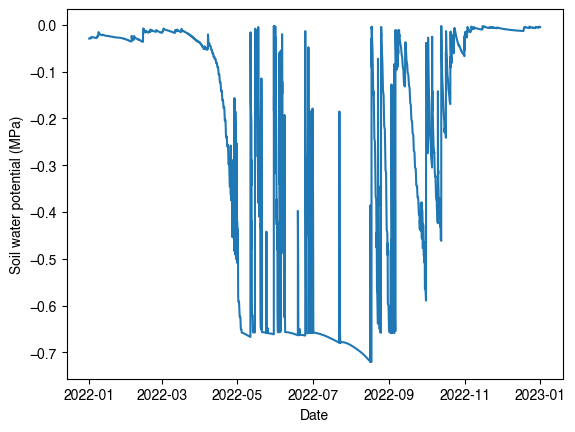

In [14]:
CABLE_data_file_address = "../../Example met data/hydraulics_profitmax_manon.nc"

# Load file
CABLE_data = open_dataset(CABLE_data_file_address, decode_times=False)

# Reduce to relevant columns
CABLE_data = CABLE_data[['psi_rootzone']]

# Reduce dimentions
CABLE_data = CABLE_data.squeeze(dim=["x", "y", "patch"], drop = True)

# Get start date
CABLE_units, CABLE_reference_date = CABLE_data.time.attrs['units'].split('since')

# Change start date formating
CABLE_start_date = CABLE_reference_date.strip()[0:19].replace("-","/")

# Convert to pandas object
CABLE_data = CABLE_data.to_pandas()

# Add date time column (this needs to be done affter converting to pandas or it is treated as an aditional dimention)
CABLE_data['date time'] = date_range(start = CABLE_start_date, periods = len(CABLE_data), freq = '30MIN')

# Set the 'date time' colun as an index
CABLE_data = CABLE_data.set_index('date time')

# Add to environmental properties data frame
metoffice_data['soil water potential'] = CABLE_data['psi_rootzone']

print(metoffice_data['soil water potential'])

plt.plot(metoffice_data.index, metoffice_data['soil water potential'])
plt.xlabel("Date")
plt.ylabel("Soil water potential (MPa)")
plt.show()

## Resampling the data

Currently the met data we are working with contains a years worth of measurments seperated byhalf an hour totaling $17520$ entries. To reduce the computation time we will reduce the data to be every six hours (reducing the data to $1460$ entries).

In [15]:
current_time_step = 0.5 #h
target_time_step = 4 #h

resample_step = int(target_time_step / current_time_step)
print("resample step: ", resample_step, "\n")

metoffice_data = metoffice_data.iloc[::resample_step, :]

print(metoffice_data)

resample step:  8 

                        Tair      Qair     Psurf  CO2air      SWdown  \
date time                                                              
2022-01-01 00:00:00  289.322  0.006778  101.6080  418.56    0.000000   
2022-01-01 04:00:00  285.595  0.006819  101.6600  418.56    0.000000   
2022-01-01 08:00:00  284.676  0.006887  101.8470  418.56    0.029130   
2022-01-01 12:00:00  287.113  0.007292  102.0500  418.56  149.086957   
2022-01-01 16:00:00  286.181  0.007710  102.1730  418.56    5.426087   
...                      ...       ...       ...     ...         ...   
2022-12-31 04:00:00  287.178  0.007657   99.6126  418.56    0.000000   
2022-12-31 08:00:00  285.315  0.006870   99.3057  418.56    0.000000   
2022-12-31 12:00:00  285.686  0.006994   98.6717  418.56   17.734783   
2022-12-31 16:00:00  290.427  0.007072   98.3858  418.56    0.873043   
2022-12-31 20:00:00  285.059  0.006329  100.0720  418.56    0.000000   

                          VPD  Photosynthet

# Applying the model

Now that we have the necessary data the next step is to creat the model.

## Hydraulic cost model

In [16]:
hydraulic_conductance_model = \
    CumulativeWeibullDistribution(maximum_conductance = 1.6659, # mmol m-2 s-1 MPa-1
                                  sensitivity_parameter = -7.740170420442604, # MPa
                                  shape_parameter = 4.969847639573251) # unitless


critical_leaf_water_potential = hydraulic_conductance_model.water_potential_from_conductivity_loss_fraction(0.95)

print("critical leaf water potential: ", critical_leaf_water_potential, "mmol m-2 s-1 MPa-1")

hydraulic_cost_model = HydraulicCostModel(hydraulic_conductance_model = hydraulic_conductance_model,
                                          critical_leaf_water_potential = critical_leaf_water_potential)

critical leaf water potential:  -9.652266781105459 mmol m-2 s-1 MPa-1


## Leaf atmostpher coupling

In [17]:
leaf_air_coupling_model = LeafAirCouplingModel()

## Photosynthesis model
### Rubisco rate limited

In [18]:
# -- Rubisco rates model --
maximum_carboxylation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 30.,
                                                        activation_energy = 60000.,
                                                        deactivation_energy = 200000.,
                                                        entropy_term = 650.)

maximum_oxegentation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 60.,
                                                       activation_energy = 30000.,
                                                       deactivation_energy = 200000.,
                                                       entropy_term = 650.)

michaelis_menten_constant_CO2_model = ArrheniusModel(rate_at_25_centigrade=404.9,
                                                     activation_energy=79430.0)

michaelis_menten_constant_O_model = ArrheniusModel(rate_at_25_centigrade=278.4,
                                                   activation_energy=36380.0)

rubisco_rates_model = RubiscoRates(maximum_carboxylation_rate_model,
                                   maximum_oxegentation_rate_model,
                                   michaelis_menten_constant_CO2_model,
                                   michaelis_menten_constant_O_model)

# -- CO2 compensation point --
CO2_compensation_point_model = ArrheniusModel(rate_at_25_centigrade = 42.75,
                                              activation_energy = 37830.0)

# -- mitochondrial respiration rate model --
mitochondrial_respiration_rate_model = Q10TemperatureDependenceModel(value_at_25C = 0.6,
                                                                     Q10_parameter = 2.)

# -- Rubisco limited model --
photosynthesis_rubisco_limited_model = PhotosynthesisModelRubiscoLimited(rubisco_rates_model = rubisco_rates_model,
                                                                         CO2_compensation_point_model = CO2_compensation_point_model,
                                                                         mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)

### Electron transport limited model

In [19]:
# -- Electron transport rate --
maximum_electron_transport_rate_model = LowTemperatureAdjustedModel(PeakedArrheniusModel(rate_at_25_centigrade = 60., 
                                                                                         activation_energy = 30000., 
                                                                                         deactivation_energy = 200000., 
                                                                                         entropy_term = 650.),
                                                                   lower_bound_C = 0.,
                                                                   upper_bound_C = 10.)

electron_transport_rate_model = ElectronTransportRateModel(curvature_parameter = 0.85,
                                                           maximum_electron_transport_rate_model = maximum_electron_transport_rate_model)

# -- Electron transport rate limmited model --
# Note the CO2 compensation point and mitochondrial respiration rate models are the same as that for the Rubisco limited model
photosynthesis_electron_transport_limited_model = PhotosynthesisModelElectronTransportLimited(electron_transport_rate_model = electron_transport_rate_model,
                                                                                              CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                              mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model,
                                                                                              rubisco_rates_model=rubisco_rates_model)

### Combined model

In [20]:
photosynthesis_model = PhotosynthesisModel(photosynthesis_rubisco_limited_model = photosynthesis_rubisco_limited_model,
                                           photosynthesis_electron_transport_limited_model = photosynthesis_electron_transport_limited_model)

## CO2 gain model

In [21]:
CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

## Profit optimisation model

In [22]:
profit_optimisation_model = ProfitMaxModel(hydraulic_cost_model,
                                           leaf_air_coupling_model,
                                           CO2_gain_model)

## Running the model on real data
We can now apply the model to calculate the optimal leaf water potential along with the net CO2 uptake and transpiration rate.

In [23]:
model_results = metoffice_data.copy()

(model_results['leaf water potential'],
 model_results['net CO2 uptake'],
 model_results['transpiration rates'],
 model_results['intercellular CO2 concentration'],
 model_results['stomatal conductance to CO2']) = \
    run_optimisation_model_on_data(profit_optimisation_model,
                                   time_steps = model_results.index.to_numpy(),
                                   soil_water_potential_values = model_results['soil water potential'].to_numpy(),
                                   air_temperature_values = model_results['Tair'].to_numpy(),
                                   air_vapour_pressure_deficit_values = model_results['VPD'].to_numpy(),
                                   air_pressure_values = model_results['Psurf'].to_numpy(),
                                   atmospheric_CO2_concentration_values = model_results['CO2air'].to_numpy(),
                                   intercellular_oxygen_values = model_results['intercellular oxygen'].to_numpy(),
                                   photosynthetically_active_radiation_values = model_results['Photosynthetically active radiation'].to_numpy(),
                                   number_of_leaf_water_potential_sample_points = 100)

# Plotting the ressults

Having applied the model to the met data we can plot how the results change over the year.

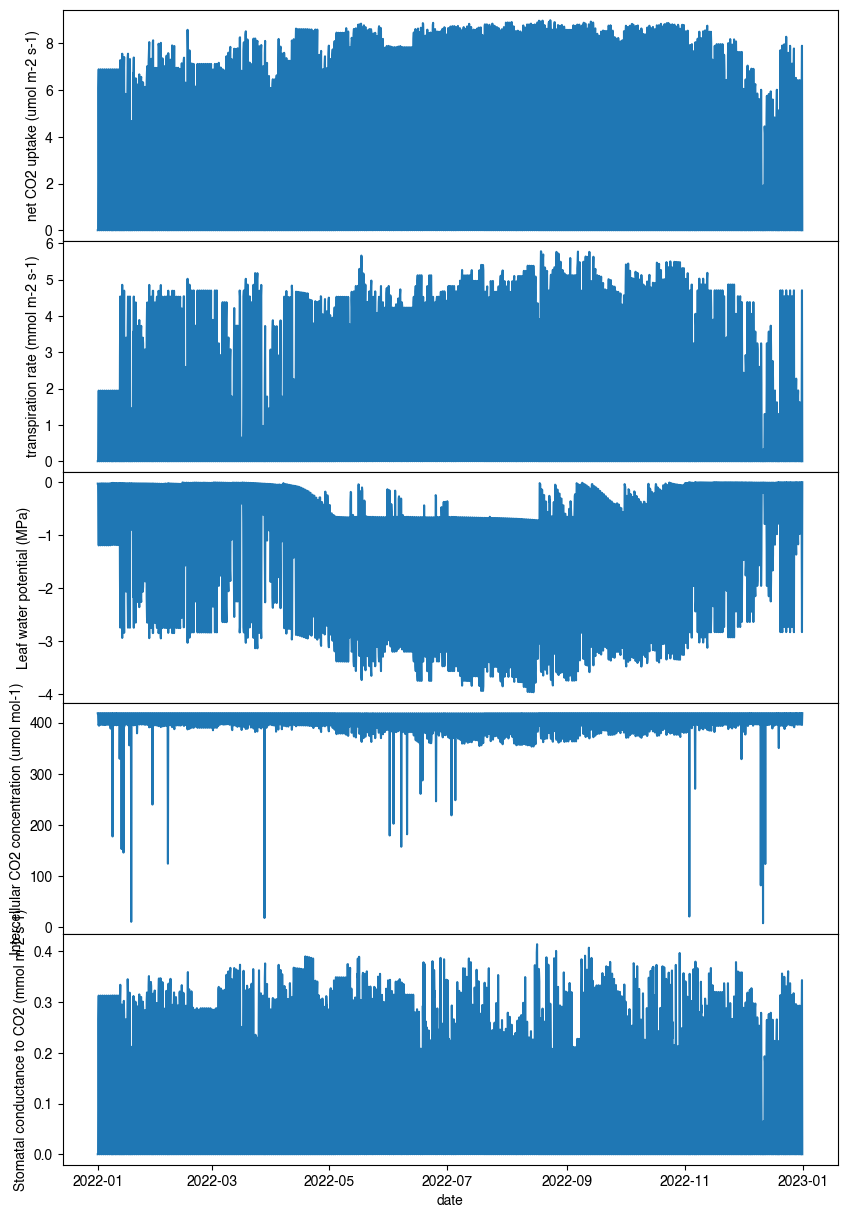

In [24]:
fig, axis = plt.subplots(5, sharex=True)

# Plot the data
axis[0].plot(model_results.index.to_numpy(), model_results['net CO2 uptake'].to_numpy())
axis[1].plot(model_results.index.to_numpy(), model_results['transpiration rates'].to_numpy())
axis[2].plot(model_results.index.to_numpy(), model_results['leaf water potential'].to_numpy())
axis[3].plot(model_results.index.to_numpy(), model_results['intercellular CO2 concentration'].to_numpy())
axis[4].plot(model_results.index.to_numpy(), model_results['stomatal conductance to CO2'].to_numpy())

# Add labels
axis[0].set_ylabel("net CO2 uptake (umol m-2 s-1)")
axis[1].set_ylabel("transpiration rate (mmol m-2 s-1)")
axis[2].set_ylabel("Leaf water potential (MPa)")
axis[3].set_ylabel("Intercellular CO2 concentration (umol mol-1)")
axis[4].set_ylabel("Stomatal conductance to CO2 (mmol m-2 s-1)")
axis[4].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)

For consistency later we want to change the $\text{CO}_2$ uptake from $\text{umol m}^{-2}\text{ s}^{-1}$ to $\text{g C m}^{-2}\text{ s}^{-1}$.

In [25]:
print(model_results['net CO2 uptake'])

model_results['net CO2 uptake umol m-2 s-1'] = model_results['net CO2 uptake']

# Convert from umol to mol
model_results['net CO2 uptake'] = magnitude_conversion(model_results['net CO2 uptake'], 'u', '')

print(model_results['net CO2 uptake'])

# Convert from mol to g
model_results['net CO2 uptake'] = mole_carbon_to_grams(model_results['net CO2 uptake'])

print(model_results['net CO2 uptake'])

date time
2022-01-01 00:00:00    0.000000
2022-01-01 04:00:00    0.000000
2022-01-01 08:00:00    6.088959
2022-01-01 12:00:00    6.890164
2022-01-01 16:00:00    2.147344
                         ...   
2022-12-31 04:00:00    0.000000
2022-12-31 08:00:00    0.000000
2022-12-31 12:00:00    5.931361
2022-12-31 16:00:00    7.896965
2022-12-31 20:00:00    0.000000
Name: net CO2 uptake, Length: 2190, dtype: float64
date time
2022-01-01 00:00:00    0.000000
2022-01-01 04:00:00    0.000000
2022-01-01 08:00:00    0.000006
2022-01-01 12:00:00    0.000007
2022-01-01 16:00:00    0.000002
                         ...   
2022-12-31 04:00:00    0.000000
2022-12-31 08:00:00    0.000000
2022-12-31 12:00:00    0.000006
2022-12-31 16:00:00    0.000008
2022-12-31 20:00:00    0.000000
Name: net CO2 uptake, Length: 2190, dtype: float64
date time
2022-01-01 00:00:00    0.000000
2022-01-01 04:00:00    0.000000
2022-01-01 08:00:00    0.000073
2022-01-01 12:00:00    0.000083
2022-01-01 16:00:00    0.000026
    

We also want to convert the transpiraion rate from $\text{mmol m}^{-2}\text{ s}^{-1}$ to $\text{Wm}^{-2}$

In [26]:
model_results['latent energy'] = magnitude_conversion(model_results['transpiration rates'], 'm', '')

model_results['latent energy'] = convert_transpiration_rate_to_latent_energy(model_results['latent energy'], model_results['Tair'])

Having made these changes we can replot the results of the model

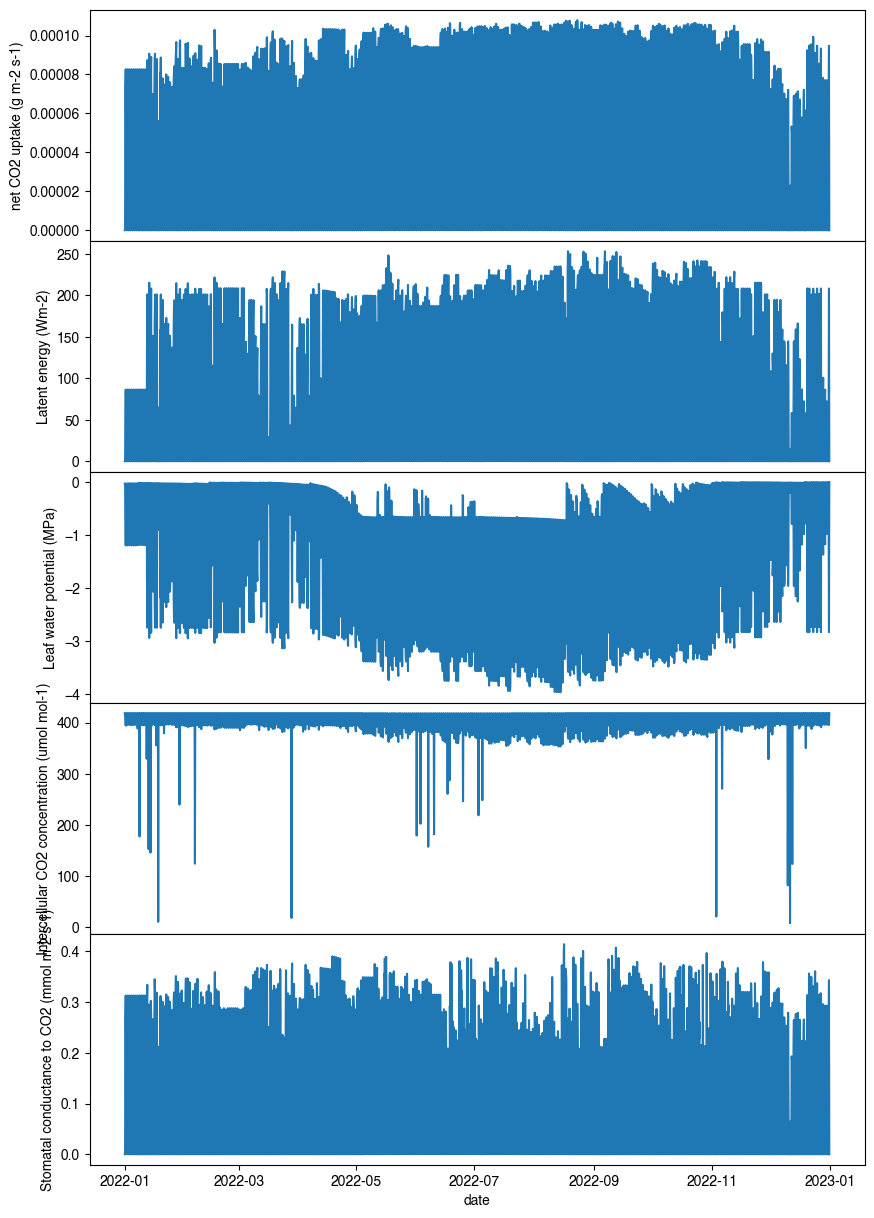

In [27]:
fig, axis = plt.subplots(5, sharex=True)

# Plot the data
axis[0].plot(model_results.index.to_numpy(), model_results['net CO2 uptake'].to_numpy())
axis[1].plot(model_results.index.to_numpy(), model_results['latent energy'].to_numpy())
axis[2].plot(model_results.index.to_numpy(), model_results['leaf water potential'].to_numpy())
axis[3].plot(model_results.index.to_numpy(), model_results['intercellular CO2 concentration'].to_numpy())
axis[4].plot(model_results.index.to_numpy(), model_results['stomatal conductance to CO2'].to_numpy())

# Add labels
axis[0].set_ylabel("net CO2 uptake (g m-2 s-1)")
axis[1].set_ylabel("Latent energy (Wm-2)")
axis[2].set_ylabel("Leaf water potential (MPa)")
axis[3].set_ylabel("Intercellular CO2 concentration (umol mol-1)")
axis[4].set_ylabel("Stomatal conductance to CO2 (mmol m-2 s-1)")
axis[4].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)

There is a lot of noise in these plots, this is due to us ploting the results every half hour throughout the day. To solve this problem we resample the net $CO_2$ uptake to per day, calculate the mean transpiration rate for each day and record the leaf water potential at pre dawn (6 am) and midday.

In [28]:
# We want the net CO2 per day and the average transpiration rate so lets use padas resample
model_results_per_day = model_results[['net CO2 uptake', 'latent energy', 'transpiration rates', 'intercellular CO2 concentration', 'stomatal conductance to CO2', 'CO2air']].copy()

# net CO2 uptake is currently per second so we need to convert to per timestep
model_results_per_day['net CO2 uptake'] = model_results_per_day['net CO2 uptake'] * target_time_step * 60 * 60

# Resample per time step to per day
model_results_per_day = model_results_per_day.resample('D').agg({'net CO2 uptake':'sum', 'latent energy':'mean', 'transpiration rates':'mean', 'intercellular CO2 concentration':'mean', 'stomatal conductance to CO2':'mean', 'CO2air':'mean'})

# Get the predawn and miday leaf water potential. This code shifts the values to the start of the day then pandas matches them based on the asigned time
model_results_per_day['predawn leaf water potential'] = model_results['leaf water potential'].resample("D", offset = "4h").asfreq().iloc[1:].to_numpy()
model_results_per_day['midday leaf water potential'] = model_results['leaf water potential'].resample("D", offset = "12h" ).asfreq().iloc[1:].to_numpy()
model_results_per_day['Tair midday'] = model_results['Tair'].resample("D", offset = '12h').asfreq().iloc[1:].to_numpy()
model_results_per_day['soil water potential midday'] = model_results['soil water potential'].resample("D", offset = '12h').asfreq().iloc[1:].to_numpy()

print(model_results_per_day)

            net CO2 uptake  latent energy  transpiration rates  \
date time                                                        
2022-01-01        2.613854      23.997160             0.539763   
2022-01-02        3.222201      28.803609             0.647862   
2022-01-03        2.745027      25.204099             0.566908   
2022-01-04        3.118356      27.602953             0.620859   
2022-01-05        3.363167      30.001813             0.674811   
...                    ...            ...                  ...   
2022-12-27        2.599016      64.749518             1.459578   
2022-12-28        1.794606      30.012891             0.676415   
2022-12-29        2.746230      37.246504             0.838681   
2022-12-30        1.522604      22.819535             0.514084   
2022-12-31        2.389535      45.541784             1.027327   

            intercellular CO2 concentration  stomatal conductance to CO2  \
date time                                                        

Plotting the resampled results.

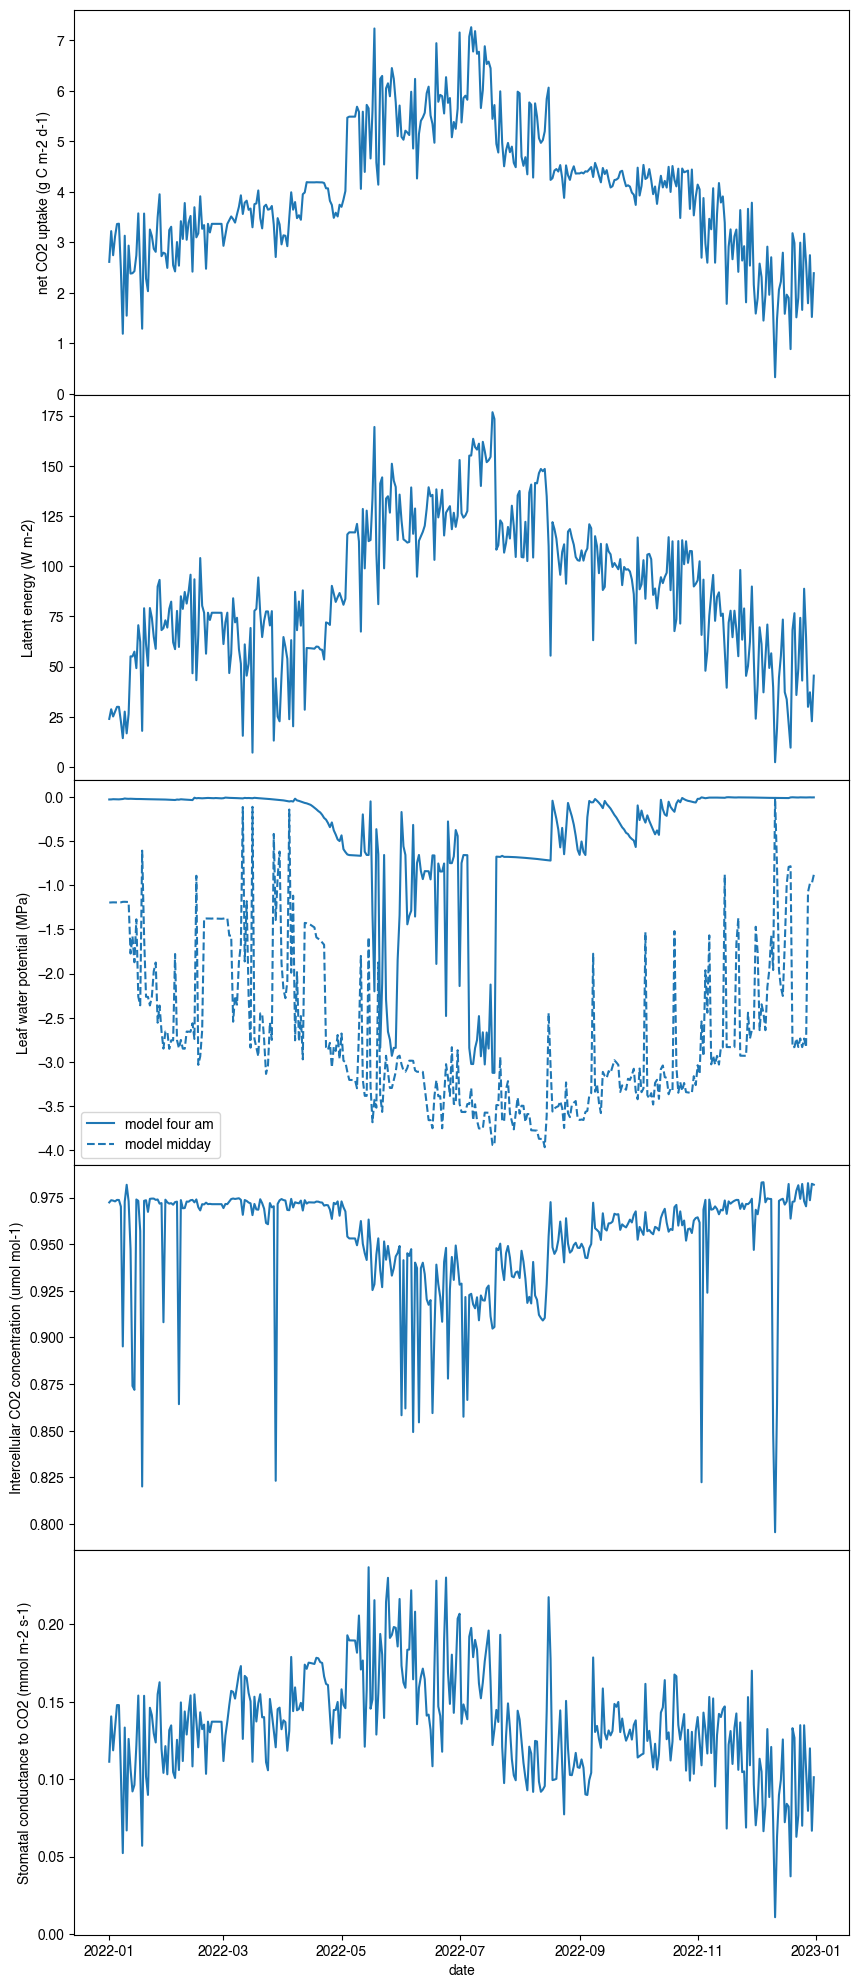

In [29]:
fig, axis = plt.subplots(5, sharex=True)

# Plot the net CO2 uptake
axis[0].plot(model_results_per_day.index.to_numpy(), model_results_per_day['net CO2 uptake'].to_numpy(), label = 'implimented model')


# Plot the average latent heat flux for each day
axis[1].plot(model_results_per_day.index.to_numpy(), model_results_per_day['latent energy'].to_numpy(), label = 'implimented model')


# Plot the leaf water potential
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['predawn leaf water potential'].to_numpy(), label = 'model four am', c = '#1f77b4')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['midday leaf water potential'].to_numpy() , label = 'model midday', c = '#1f77b4', linestyle = '--')
axis[2].legend()


axis[3].plot(model_results_per_day.index.to_numpy(), model_results_per_day['intercellular CO2 concentration'].to_numpy()/model_results_per_day['CO2air'])
axis[4].plot(model_results_per_day.index.to_numpy(), model_results_per_day['stomatal conductance to CO2'].to_numpy())

# Add labels
axis[0].set_ylabel("net CO2 uptake (g C m-2 d-1)")
axis[1].set_ylabel("Latent energy (W m-2)")
axis[2].set_ylabel("Leaf water potential (MPa)")
axis[3].set_ylabel("Intercellular CO2 concentration (umol mol-1)")
axis[4].set_ylabel("Stomatal conductance to CO2 (mmol m-2 s-1)")
axis[4].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,25)

# Comparing results

Now we can compare the results of running the model above to those from JULES and CABLE along with real observations. To achive this we need to first load and reformat the results files as we did for the metoffice data.

In [30]:
JULES_data_file_address = "../../Example met data/local_UK-Ham_fluxnet2015_UK-Ham.UK-Ham.nc"
CABLE_data_file_address = "../../Example met data/hydraulics_profitmax_manon.nc"
observation_data_file_address = "../../Example met data/Alice_Holt/data/alice_holt_flux_2022.nc"

# Load files
JULES_data = open_dataset(JULES_data_file_address, decode_times=False)
CABLE_data = open_dataset(CABLE_data_file_address, decode_times=False)
observation_data = open_dataset(observation_data_file_address, decode_times=False)

# Reduce to relevant columns
JULES_data = JULES_data[['GPP', 'Qle', 'fsmc']]
CABLE_data = CABLE_data[['GPP', 'Qle', 'psi_rootzone', 'psi_can', 'LAI']]
observation_data = observation_data[['Qle']]

# Reduce dimentions
JULES_data = JULES_data.squeeze(dim=["x", "y"], drop = True)
CABLE_data = CABLE_data.squeeze(dim=["x", "y", "patch"], drop = True)
observation_data = observation_data.squeeze(dim=["x", "y"], drop = True)

# Extract Beta from jules data and then drop fsmc
JULES_data['beta'] = JULES_data['fsmc'][:,0]
JULES_data = JULES_data[['GPP', 'Qle', 'beta']]

# Get start date
JULES_units, JULES_reference_date = JULES_data.time.attrs['units'].split('since')
CABLE_units, CABLE_reference_date = CABLE_data.time.attrs['units'].split('since')
observation_units, observation_reference_date = observation_data.time.attrs['units'].split('since')

# Change start date formating
JULES_start_date = JULES_reference_date.strip()[0:19].replace("-","/")
CABLE_start_date = CABLE_reference_date.strip()[0:19].replace("-","/")
observation_start_date = observation_reference_date.strip()[0:19].replace("-","/")

# Convert to pandas object
JULES_data = JULES_data.to_pandas()
CABLE_data = CABLE_data.to_pandas()
observation_data = observation_data.to_pandas()

# Add date time column (this needs to be done affter converting to pandas or it is treated as an aditional dimention)
JULES_data['date time'] = date_range(start = JULES_start_date, periods = len(JULES_data), freq = '30MIN')
CABLE_data['date time'] = date_range(start = CABLE_start_date, periods = len(CABLE_data), freq = '30MIN')
observation_data['date time'] = date_range(start = observation_start_date, periods = len(observation_data), freq = '30MIN')

# Set the 'date time' colun as an index
JULES_data = JULES_data.set_index('date time')
CABLE_data = CABLE_data.set_index('date time')

print("JULES: \n", JULES_data, "\n")
print("CABLE: \n", CABLE_data, "\n")
print("observations: \n", observation_data, "\n")

JULES: 
                      GPP       Qle  beta
date time                               
2022-01-01 00:00:00  0.0 -0.067324   1.0
2022-01-01 00:30:00  0.0 -0.079333   1.0
2022-01-01 01:00:00  0.0 -0.263981   1.0
2022-01-01 01:30:00  0.0 -0.061631   1.0
2022-01-01 02:00:00  0.0 -0.331570   1.0
...                  ...       ...   ...
2022-12-31 21:30:00  0.0 -2.954634   1.0
2022-12-31 22:00:00  0.0 -1.310926   1.0
2022-12-31 22:30:00  0.0 -1.031563   1.0
2022-12-31 23:00:00  0.0 -1.772175   1.0
2022-12-31 23:30:00  0.0 -3.248971   1.0

[17520 rows x 3 columns] 

CABLE: 
                      GPP       Qle  psi_rootzone   psi_can       LAI
date time                                                           
2022-01-01 00:00:00  0.0 -7.058563     -0.029366 -0.029366  0.599612
2022-01-01 00:30:00  0.0 -2.340145     -0.029344 -0.029344  0.599612
2022-01-01 01:00:00  0.0  0.030474     -0.029325 -0.029325  0.599612
2022-01-01 01:30:00  0.0  1.196649     -0.029308 -0.029308  0.599612
2022-01

This data needs to be converted to the same units as that produced using the model.

Let us start with the JULES data

In [31]:
JULES_data_per_day = JULES_data.copy()

# First make the carbon uptake rate grams per half hour from kilograms per second
JULES_data_per_day['GPP'] = magnitude_conversion(JULES_data_per_day['GPP'], 'k', '')
JULES_data_per_day['GPP'] = per_second_to_per_half_hour(JULES_data_per_day['GPP'])

# Resample the results to per day taking the sum of the CO2 uptake, mean latent heat and minimum beta
JULES_data_per_day = JULES_data_per_day.resample("D").agg({'GPP':'sum', 'Qle':'mean', 'beta':'min'})

print(JULES_data_per_day)

                 GPP       Qle  beta
date time                           
2022-01-01  0.782950 -0.391202   1.0
2022-01-02  0.753786 -0.797297   1.0
2022-01-03  0.799369 -0.318914   1.0
2022-01-04  0.830902 -0.402620   1.0
2022-01-05  1.158851 -0.159758   1.0
...              ...       ...   ...
2022-12-27  0.019233 -0.302093   1.0
2022-12-28  0.017166 -2.111282   1.0
2022-12-29  0.021375 -1.037430   1.0
2022-12-30  0.017020 -1.733438   1.0
2022-12-31  0.014291 -3.065119   1.0

[365 rows x 3 columns]


Now for the CABLE data.

In [32]:
CABLE_data_per_day = CABLE_data[['GPP','Qle', 'LAI']].copy()

# convert GPP from umol m-2 s-1 to g C m-2 (0.5h)-1
CABLE_data_per_day['GPP'] = magnitude_conversion(CABLE_data_per_day['GPP'], 'u', '')
CABLE_data_per_day['GPP'] = per_second_to_per_half_hour(CABLE_data_per_day['GPP'])
CABLE_data_per_day['GPP'] = mole_carbon_to_grams(CABLE_data_per_day['GPP'])

# Remove any negative latent heat so they are not averaged over
CABLE_data_per_day['Qle'].loc[CABLE_data_per_day['Qle'] < 0] = nan

# Resample
CABLE_data_per_day = CABLE_data_per_day.resample("D").agg({'GPP':'sum', 'Qle':'mean', 'LAI':'mean'})

# Add the pre dawn (6 am) and midday leaf water potentials
CABLE_data_per_day['predawn leaf water potential'] = CABLE_data['psi_can'].resample("D", offset = "4h" ).asfreq().iloc[1:].to_numpy()
CABLE_data_per_day['midday leaf water potential']  = CABLE_data['psi_can'].resample("D", offset = "12h").asfreq().iloc[1:].to_numpy()
CABLE_data_per_day['midday Qle'] = CABLE_data['Qle'].resample("D", offset = "12h").asfreq().iloc[1:].to_numpy()

print(CABLE_data_per_day)

                     GPP        Qle       LAI  predawn leaf water potential  \
date time                                                                     
2022-01-01  2.175093e-01   9.080814  0.599612                     -0.029237   
2022-01-02  7.562412e-02  17.028246  0.618078                     -0.028706   
2022-01-03  8.178637e-10  10.053499  0.637017                     -0.026279   
2022-01-04  4.172413e-02  14.993724  0.656442                     -0.027054   
2022-01-05  7.728097e-01  19.769239  0.676364                     -0.027301   
...                  ...        ...       ...                           ...   
2022-12-27  0.000000e+00   2.345288  0.000000                     -0.005895   
2022-12-28  0.000000e+00   0.239332  0.000000                     -0.005895   
2022-12-29  0.000000e+00   2.670970  0.000000                     -0.005895   
2022-12-30  0.000000e+00   0.972046  0.000000                     -0.005895   
2022-12-31  0.000000e+00        NaN  0.000000       

Now we can compare these data sets to the results of the model implimented above.

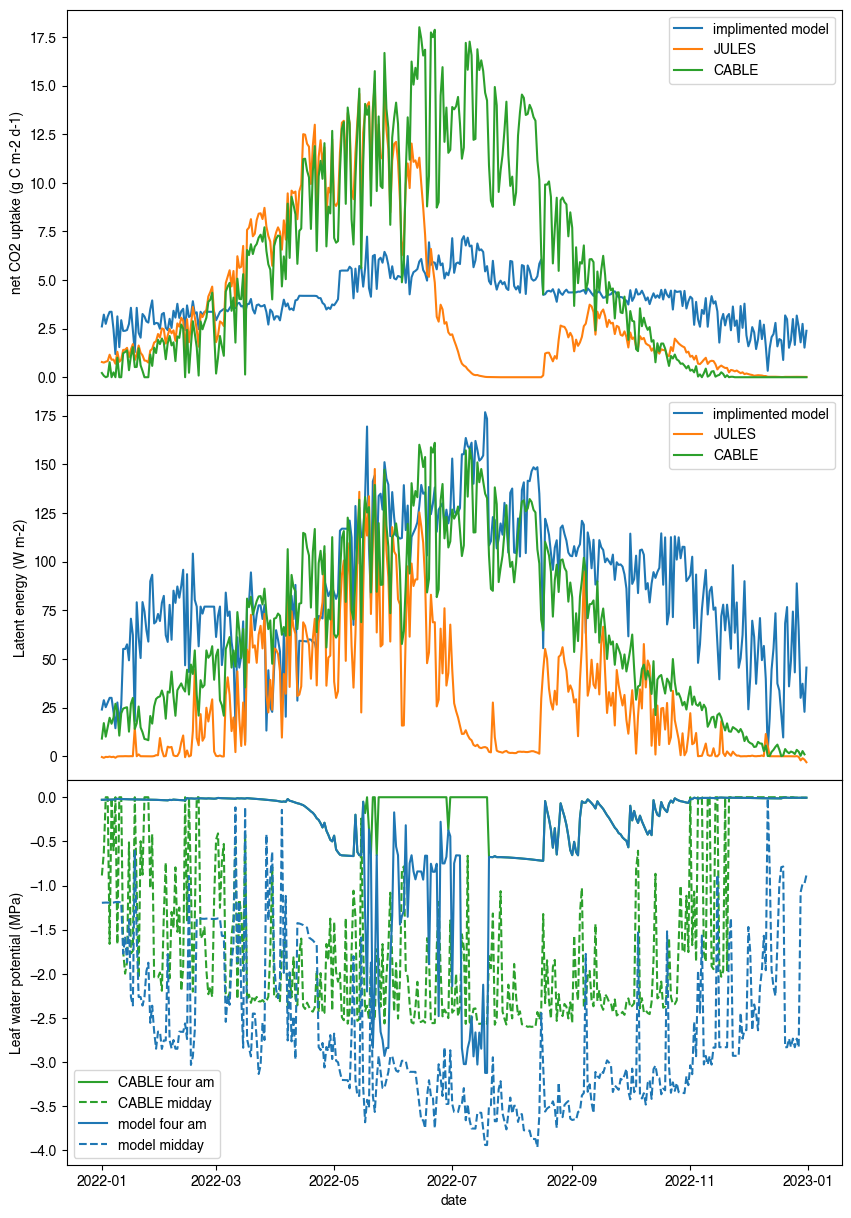

In [33]:
fig, axis = plt.subplots(3, sharex=True)

# Plot the net CO2 uptake
axis[0].plot(model_results_per_day.index.to_numpy(), model_results_per_day['net CO2 uptake'].to_numpy(), label = 'implimented model')
axis[0].plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['GPP'].to_numpy()              , label = 'JULES')
axis[0].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['GPP'].to_numpy()              , label = 'CABLE')
axis[0].legend()

# Plot the average latent heat flux for each day
axis[1].plot(model_results_per_day.index.to_numpy(), model_results_per_day['latent energy'].to_numpy(), label = 'implimented model')
axis[1].plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['Qle'].to_numpy()             , label = 'JULES')
axis[1].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['Qle'].to_numpy()             , label = 'CABLE')
axis[1].legend()

# Plot the leaf water potential
axis[2].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['predawn leaf water potential'].to_numpy()   , label = 'CABLE four am', c = '#2ca02c')
axis[2].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['midday leaf water potential'].to_numpy()    , label = 'CABLE midday', c = '#2ca02c', linestyle = '--')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['predawn leaf water potential'].to_numpy(), label = 'model four am', c = '#1f77b4')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['midday leaf water potential'].to_numpy() , label = 'model midday', c = '#1f77b4', linestyle = '--')
axis[2].legend()

# Add labels
axis[0].set_ylabel("net CO2 uptake (g C m-2 d-1)")
axis[1].set_ylabel("Latent energy (W m-2)")
axis[2].set_ylabel("Leaf water potential (MPa)")
axis[2].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)

There is a lot of noise here so lets smooth all the data using a rolling average to make it easier to read.

In [34]:
window = 4

print(model_results_per_day)
model_results_per_day = model_results_per_day.rolling(window).mean()
JULES_data_per_day = JULES_data_per_day.rolling(window).mean()
CABLE_data_per_day = CABLE_data_per_day.rolling(window).mean()
print(model_results_per_day)

            net CO2 uptake  latent energy  transpiration rates  \
date time                                                        
2022-01-01        2.613854      23.997160             0.539763   
2022-01-02        3.222201      28.803609             0.647862   
2022-01-03        2.745027      25.204099             0.566908   
2022-01-04        3.118356      27.602953             0.620859   
2022-01-05        3.363167      30.001813             0.674811   
...                    ...            ...                  ...   
2022-12-27        2.599016      64.749518             1.459578   
2022-12-28        1.794606      30.012891             0.676415   
2022-12-29        2.746230      37.246504             0.838681   
2022-12-30        1.522604      22.819535             0.514084   
2022-12-31        2.389535      45.541784             1.027327   

            intercellular CO2 concentration  stomatal conductance to CO2  \
date time                                                        

Now we can replot this smoothed data

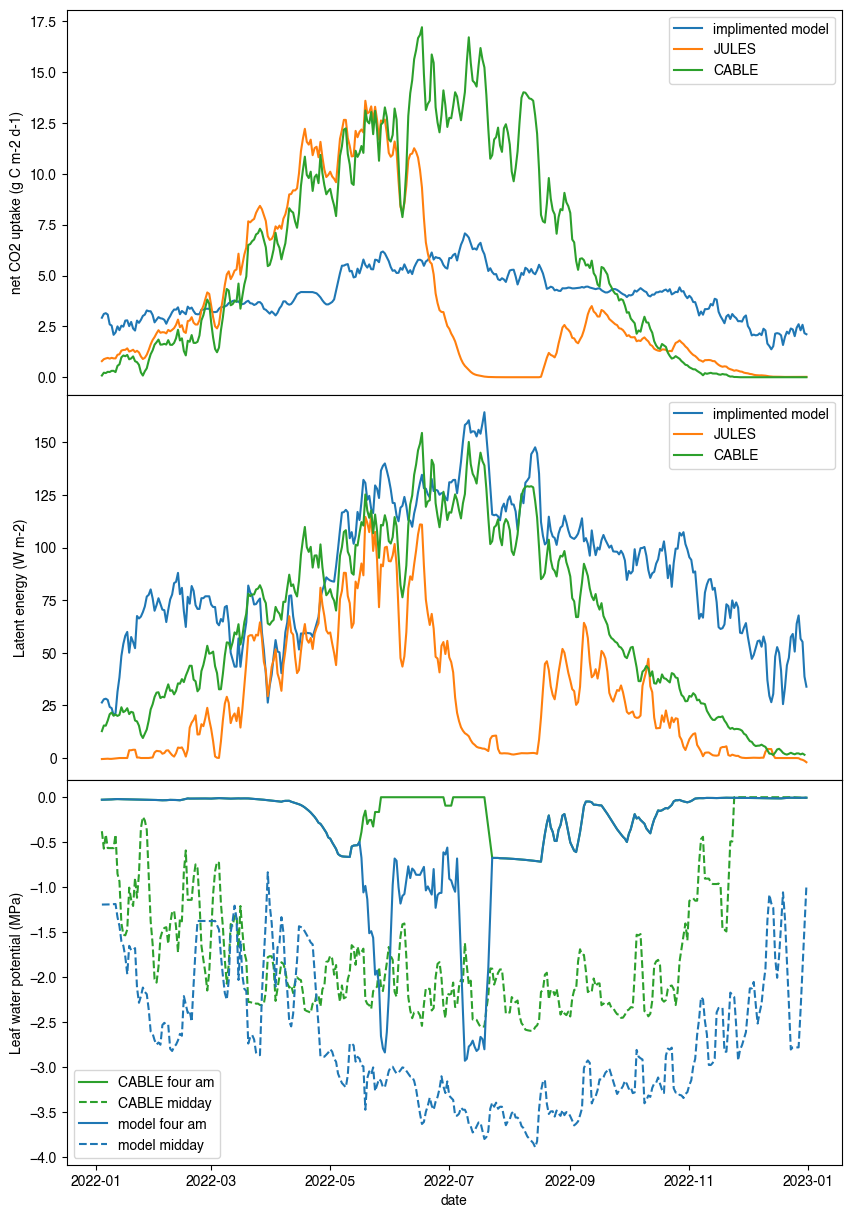

In [35]:
fig, axis = plt.subplots(3, sharex=True)

# Plot the net CO2 uptake
axis[0].plot(model_results_per_day.index.to_numpy(), model_results_per_day['net CO2 uptake'].to_numpy(), label = 'implimented model')
axis[0].plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['GPP'].to_numpy()              , label = 'JULES')
axis[0].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['GPP'].to_numpy()              , label = 'CABLE')
axis[0].legend()

# Plot the average latent heat flux for each day
axis[1].plot(model_results_per_day.index.to_numpy(), model_results_per_day['latent energy'].to_numpy(), label = 'implimented model')
axis[1].plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['Qle'].to_numpy()             , label = 'JULES')
axis[1].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['Qle'].to_numpy()             , label = 'CABLE')
axis[1].legend()

# Plot the leaf water potential
axis[2].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['predawn leaf water potential'].to_numpy()   , label = 'CABLE four am', c = '#2ca02c')
axis[2].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['midday leaf water potential'].to_numpy()    , label = 'CABLE midday', c = '#2ca02c', linestyle = '--')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['predawn leaf water potential'].to_numpy(), label = 'model four am', c = '#1f77b4')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['midday leaf water potential'].to_numpy() , label = 'model midday', c = '#1f77b4', linestyle = '--')
axis[2].legend()

# Add labels
axis[0].set_ylabel("net CO2 uptake (g C m-2 d-1)")
axis[1].set_ylabel("Latent energy (W m-2)")
axis[2].set_ylabel("Leaf water potential (MPa)")
axis[2].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)

There is clearly a scale difference between the model implimented here compared to the JULES and CABLE models. This is likly due to the leaf area index (the leaf area per unit ground area). The model implimented above has inherently assumed constant a leaf area index of one, in reality the leaf area index varies over the year for disiduous trees as they grow and loose their leaves. The correction for this is relativly simple, we need to multiply the net $\text{CO}_2$ uptake and latent energy results above by the leaf area index. The water potential is unaffected.

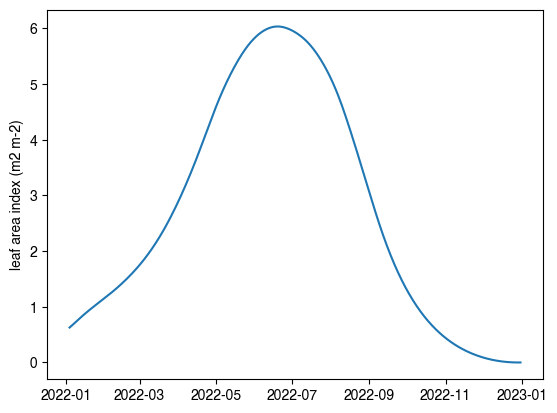

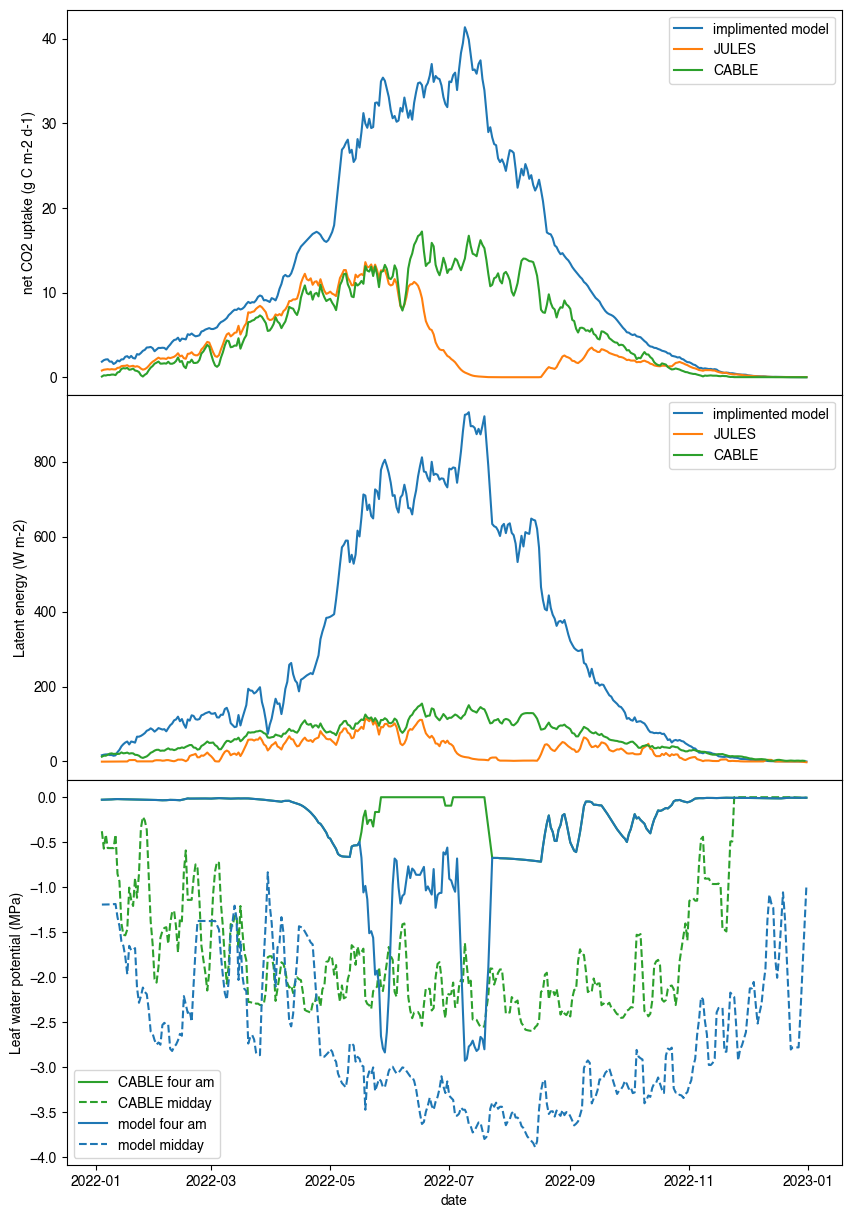

In [36]:
leaf_area_index = CABLE_data_per_day['LAI'].to_numpy() # m^2 m^-2

plt.plot(CABLE_data_per_day.index.to_numpy(), leaf_area_index)
plt.ylabel('leaf area index (m2 m-2)')
plt.show()

fig, axis = plt.subplots(3, sharex=True)

# Plot the net CO2 uptake
axis[0].plot(model_results_per_day.index.to_numpy(), leaf_area_index * model_results_per_day['net CO2 uptake'].to_numpy()  , label = 'implimented model')
#axis[0].plot(model_results_per_day.index.to_numpy(), leaf_area_index * model_results_per_day['net CO2 uptake'].to_numpy()/2, label = 'implimented model /2')
axis[0].plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['GPP'].to_numpy()              , label = 'JULES')
axis[0].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['GPP'].to_numpy()              , label = 'CABLE')
axis[0].legend()

# Plot the average latent heat flux for each da
axis[1].plot(model_results_per_day.index.to_numpy(), leaf_area_index * model_results_per_day['latent energy'].to_numpy()  , label = 'implimented model')
#axis[1].plot(model_results_per_day.index.to_numpy(), leaf_area_index * model_results_per_day['latent energy'].to_numpy()/6, label = 'implimented model /6')
axis[1].plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['Qle'].to_numpy(), label = 'JULES')
axis[1].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['Qle'].to_numpy(), label = 'CABLE')
axis[1].legend()

# Plot the leaf water potential
axis[2].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['predawn leaf water potential'].to_numpy()   , label = 'CABLE four am', c = '#2ca02c')
axis[2].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['midday leaf water potential'].to_numpy()    , label = 'CABLE midday', c = '#2ca02c', linestyle = '--')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['predawn leaf water potential'].to_numpy(), label = 'model four am', c = '#1f77b4')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['midday leaf water potential'].to_numpy() , label = 'model midday', c = '#1f77b4', linestyle = '--')
axis[2].legend()

# Add labels
axis[0].set_ylabel("net CO2 uptake (g C m-2 d-1)")
axis[1].set_ylabel("Latent energy (W m-2)")
axis[2].set_ylabel("Leaf water potential (MPa)")
axis[2].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)

# Testing the model

Bellow are a series of test used to try and identify why the model deviates from the CABLE and JULES results.

First we recalculate the transpiration rate from the stomatal conductance to $\text{CO}_2$.

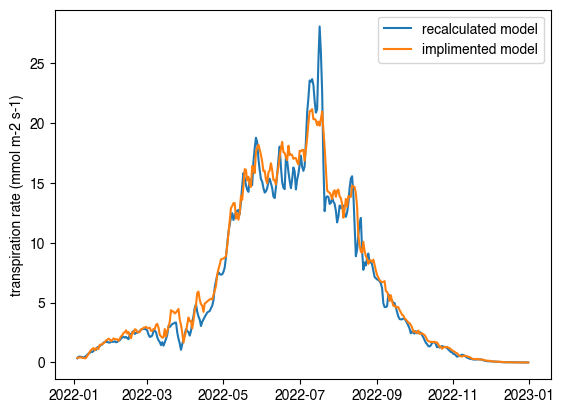

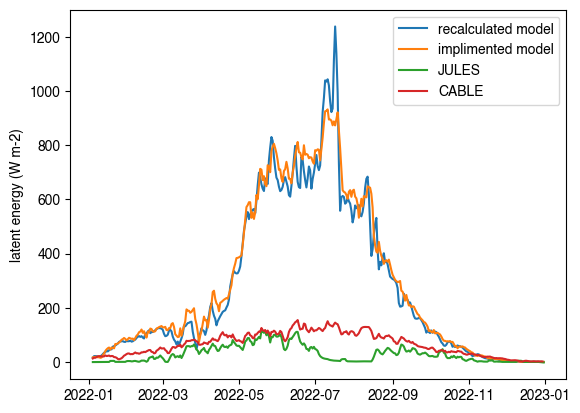

In [37]:
from numpy import cumsum, pad, nan_to_num

conductance_to_water = convert_stomatal_conductance_of_carbon_to_water(model_results_per_day['stomatal conductance to CO2']).to_numpy()

VPD = model_results['VPD'].resample('D').agg({'VPD':'mean'}).to_numpy()[:,0]
Pressure = model_results['Psurf'].resample('D').agg({'Psurf':'mean'}).to_numpy()[:,0]
air_temperature_K = model_results['Tair'].resample('D').agg({'Tair':'mean'}).to_numpy()[:,0]

recalculated_transpiration_rate = VPD * conductance_to_water / Pressure

recalculated_transpiration_rate = nan_to_num(recalculated_transpiration_rate)

# get rolling average
recalculated_transpiration_rate = cumsum(recalculated_transpiration_rate)
recalculated_transpiration_rate = recalculated_transpiration_rate[window:]-recalculated_transpiration_rate[:-window]
recalculated_transpiration_rate = recalculated_transpiration_rate/window

recalculated_transpiration_rate = pad(recalculated_transpiration_rate, (2,2), mode = 'empty')

plt.plot(model_results_per_day.index.to_numpy(), leaf_area_index *1000*recalculated_transpiration_rate, label = 'recalculated model')
plt.plot(model_results_per_day.index.to_numpy(), leaf_area_index *model_results_per_day['transpiration rates'].to_numpy(), label = 'implimented model')
plt.legend()
plt.ylabel('transpiration rate (mmol m-2 s-1)')
plt.show()

recalculated_latent_heat_flux = convert_transpiration_rate_to_latent_energy(recalculated_transpiration_rate, air_temperature_K)

plt.plot(model_results_per_day.index.to_numpy(), leaf_area_index *recalculated_latent_heat_flux                    , label = 'recalculated model')
plt.plot(model_results_per_day.index.to_numpy(), leaf_area_index *model_results_per_day['latent energy'].to_numpy(), label = 'implimented model')
plt.plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['Qle'].to_numpy()                              , label = 'JULES')
plt.plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['Qle'].to_numpy()                              , label = 'CABLE')
plt.legend()
plt.ylabel('latent energy (W m-2)')
plt.show()

Bellow the stomatal conductance to $\text{CO}_2$ is calculated from the models net $\text{CO}_2$ uptake, intercellular $\text{CO}_2$ concentration and the measured $\text{CO}_2$ concentration in the air.

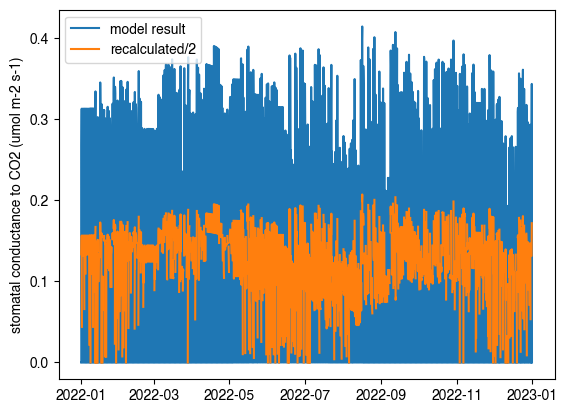

In [38]:
recalculated_stomatal_conductance_to_CO2 = model_results['net CO2 uptake umol m-2 s-1'] / (model_results['CO2air'] - model_results['intercellular CO2 concentration'])

plt.plot(model_results.index.to_numpy(), model_results['stomatal conductance to CO2'].to_numpy(), label = 'model result')
plt.plot(model_results.index.to_numpy(), 0.5*recalculated_stomatal_conductance_to_CO2, label = 'recalculated/2')
plt.ylabel('stomatal conductance to CO2 (umol m-2 s-1)')
plt.legend()
plt.show()

The code bellow calculates the transpiration rate using the leaf and soil potentials extracted from the CABLE data. This is then compared to the transpiration rate calculated by CABLE. It is clear that the transpiration calculated by the model is roughly double that calculated using the CABLE implimentation despite using the same water potential range.

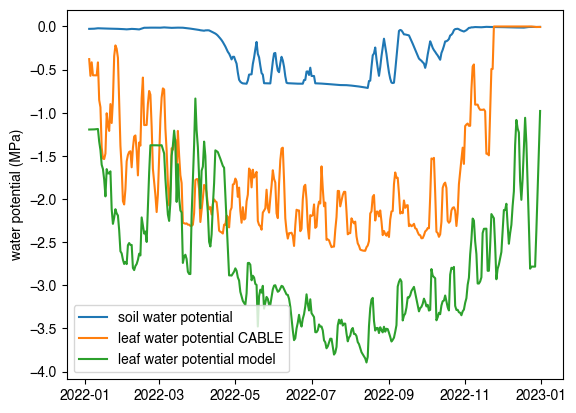

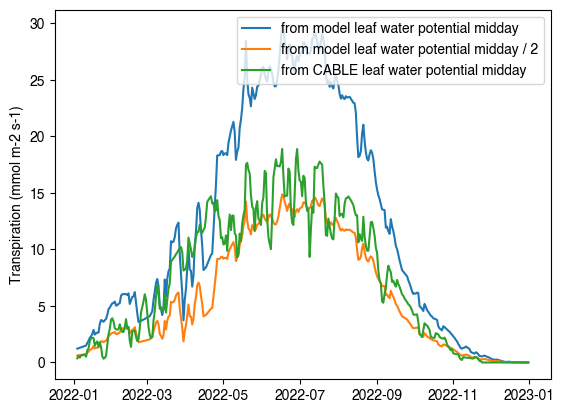

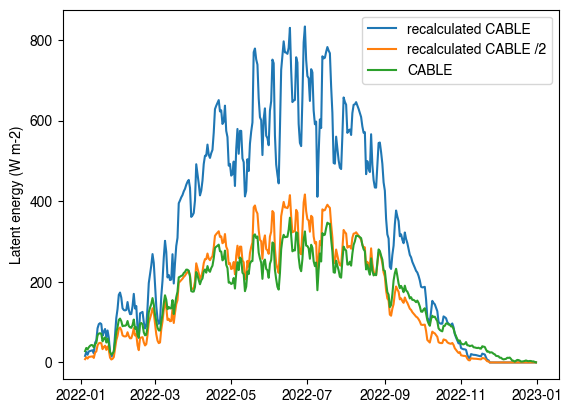

In [39]:
from numpy import zeros

transpiration_from_water_potentials_CABLE_midday = zeros(len(CABLE_data_per_day))
transpiration_from_water_potentials_model_midday = zeros(len(model_results_per_day))
leaf_water_potentials_CABLE = CABLE_data_per_day['midday leaf water potential'].to_numpy()
leaf_water_potentials_model = model_results_per_day['midday leaf water potential'].to_numpy()
soil_water_potentials_midday = model_results_per_day['soil water potential midday'].to_numpy()

plt.plot(model_results_per_day.index.to_numpy(), soil_water_potentials_midday, label = 'soil water potential')
plt.plot(CABLE_data_per_day.index.to_numpy(), leaf_water_potentials_CABLE, label = 'leaf water potential CABLE')
plt.plot(model_results_per_day.index.to_numpy(), leaf_water_potentials_model, label = 'leaf water potential model')
plt.legend()
plt.ylabel('water potential (MPa)')
plt.show()

for i in range(len(CABLE_data_per_day)):
    transpiration_from_water_potentials_CABLE_midday[i] = -hydraulic_conductance_model.transpiration(soil_water_potentials_midday[i], leaf_water_potentials_CABLE[i])
    
for i in range(len(model_results_per_day)):
    transpiration_from_water_potentials_model_midday[i] = -hydraulic_conductance_model.transpiration(soil_water_potentials_midday[i], leaf_water_potentials_model[i])
    
    
plt.plot(model_results_per_day.index.to_numpy(), leaf_area_index*transpiration_from_water_potentials_model_midday, label = 'from model leaf water potential midday')
plt.plot(model_results_per_day.index.to_numpy(), leaf_area_index*transpiration_from_water_potentials_model_midday/2, label = 'from model leaf water potential midday / 2')
plt.plot(CABLE_data_per_day.index.to_numpy(), leaf_area_index*transpiration_from_water_potentials_CABLE_midday, label = 'from CABLE leaf water potential midday')
plt.legend()
plt.ylabel("Transpiration (mmol m-2 s-1)")
plt.show()

latent_energy_from_water_potentials_CABLE_midday = convert_transpiration_rate_to_latent_energy(transpiration_from_water_potentials_CABLE_midday/1000, model_results_per_day['Tair midday'])

plt.plot(CABLE_data_per_day.index.to_numpy(), leaf_area_index*latent_energy_from_water_potentials_CABLE_midday, label = 'recalculated CABLE')
plt.plot(CABLE_data_per_day.index.to_numpy(), leaf_area_index*latent_energy_from_water_potentials_CABLE_midday/2, label = 'recalculated CABLE /2')
plt.plot(CABLE_data_per_day.index.to_numpy(), CABLE_data_per_day['midday Qle'].to_numpy(), label = 'CABLE')
plt.ylabel("Latent energy (W m-2)")
plt.legend()
plt.show()

The code bellow tests the transpiration to latent energy conversion based on the JULES data as it contains both the vegitation transpiration and latent energy. The air temperature is not obveously available so we make do by using the temperature at 1.5m (the lable for this being 't1p5m').

                     TVeg       Qle       t1p5m
date time                                      
2022-01-01 00:00:00   0.0 -0.067324  277.813110
2022-01-01 00:30:00   0.0 -0.079333  277.802734
2022-01-01 01:00:00   0.0 -0.263981  277.824921
2022-01-01 01:30:00   0.0 -0.061631  277.687714
2022-01-01 02:00:00   0.0 -0.331570  277.703400
...                   ...       ...         ...
2022-12-31 21:30:00   0.0 -2.954634  278.257080
2022-12-31 22:00:00   0.0 -1.310926  278.130707
2022-12-31 22:30:00   0.0 -1.031563  278.054047
2022-12-31 23:00:00   0.0 -1.772175  277.986633
2022-12-31 23:30:00   0.0 -3.248971  278.019104

[17520 rows x 3 columns]
                     TVeg       Qle       t1p5m  Qle recalculated
date time                                                        
2022-01-01 00:00:00   0.0 -0.067324  277.813110               0.0
2022-01-01 04:00:00   0.0 -0.445240  277.547485               0.0
2022-01-01 08:00:00   0.0 -0.988694  277.223969               0.0
2022-01-01 12:00:00 

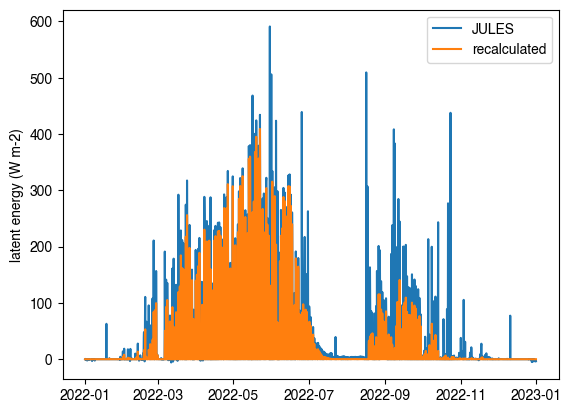

In [40]:
from src.conversions import gram_water_to_mole

JULES_transpiration_data = open_dataset(JULES_data_file_address, decode_times=False)[['TVeg','Qle','t1p5m']]

JULES_transpiration_data = JULES_transpiration_data.squeeze(dim=["x", "y"], drop = True)

# Convert to pandas object
JULES_transpiration_data = JULES_transpiration_data.to_pandas()

# Add date time column (this needs to be done affter converting to pandas or it is treated as an aditional dimention)
JULES_transpiration_data['date time'] = JULES_data.index.to_numpy()

# Set the 'date time' colun as an index
JULES_transpiration_data = JULES_transpiration_data.set_index('date time')


print(JULES_transpiration_data)

JULES_transpiration_data = JULES_transpiration_data.resample('4h').first()

JULES_transpiration_data['Qle recalculated'] = magnitude_conversion(JULES_transpiration_data['TVeg'], 'k', '')

print(JULES_transpiration_data)

JULES_transpiration_data['Qle recalculated'] = gram_water_to_mole(JULES_transpiration_data['Qle recalculated'])

print(JULES_transpiration_data)
print(len(model_results['Tair'].to_numpy()))
JULES_transpiration_data['Qle recalculated'] = convert_transpiration_rate_to_latent_energy(JULES_transpiration_data['Qle recalculated'].to_numpy(), JULES_transpiration_data['t1p5m'].to_numpy())

print(JULES_transpiration_data)

plt.plot(JULES_transpiration_data.index.to_numpy(), JULES_transpiration_data['Qle'], label = 'JULES')
plt.plot(JULES_transpiration_data.index.to_numpy(), JULES_transpiration_data['Qle recalculated'], label = 'recalculated')
plt.ylabel('latent energy (W m-2)')
plt.legend()
plt.show()